# RQ1

### Distribution of Top-20 Domains

/var/folders/kr/pgq9gfts7j3bn4n2v53xh98m0000gn/T/ipykernel_80234/642241189.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_combined_df['top1_domain'] = all_combined_df['top_domains'].apply(extract_top1_domain)


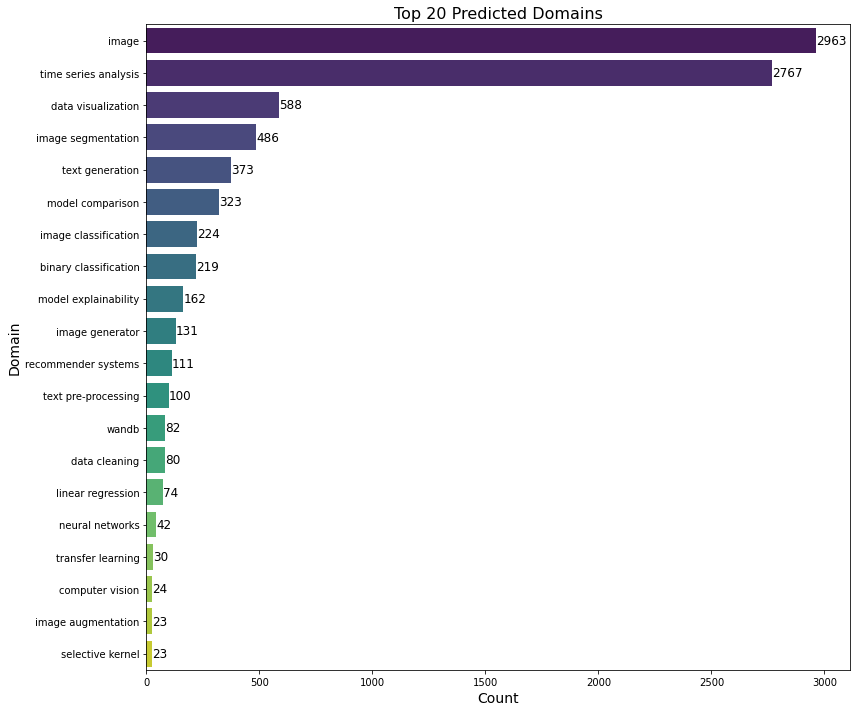

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter

df = pd.read_csv('domain_classification_results.csv')

all_combined_df = df[df['part'] == 'all combined']

def extract_top1_domain(top_domains_str):
    try:
        domains = ast.literal_eval(top_domains_str)
        if domains and len(domains) > 0:
            return domains[0]
    except:
        import re
        matches = re.findall(r"'(.*?)'", top_domains_str)
        if matches:
            return matches[0]
    return "Unknown"

all_combined_df['top1_domain'] = all_combined_df['top_domains'].apply(extract_top1_domain)

domain_counts = Counter(all_combined_df['top1_domain'])
top_domains = domain_counts.most_common(20)

domains = [x[0] for x in top_domains]
counts = [x[1] for x in top_domains]

plt.figure(figsize=(12, 10))
ax = sns.barplot(y=domains, x=counts, palette='viridis', orient='h')

plt.title('Top 20 Predicted Domains', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Domain', fontsize=14)

for i, count in enumerate(counts):
    ax.text(count + 0.5, i, str(count), va='center', fontsize=12)

plt.tight_layout()
# plt.savefig('top_domains_distribution.png', dpi=300)
plt.show()

### LLM Domain Relevance Eval Fig

<Figure size 1008x576 with 0 Axes>

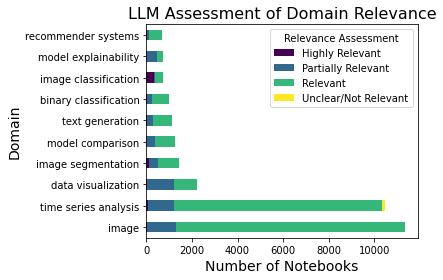

<Figure size 1008x576 with 0 Axes>

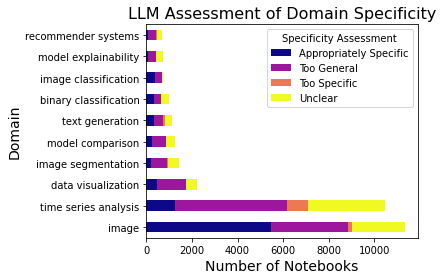

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re


df = pd.read_csv('qualitative.csv')  


# Function to categorize LLM responses
def categorize_relevance(text):
    if not isinstance(text, str):
        return "Unknown"
    
    text = text.lower()
    if 'highly relevant' in text or 'very relevant' in text:
        return "Highly Relevant"
    elif 'relevant' in text and 'highly relevant' not in text and 'very relevant' not in text and 'partially' not in text and 'somewhat' not in text:
        return "Relevant"
    elif 'partially' in text or 'somewhat' in text:
        return "Partially Relevant"
    else:
        return "Unclear/Not Relevant"

def categorize_specificity(text):
    if not isinstance(text, str):
        return "Unknown"
    
    text = text.lower()
    if 'very specific' in text or 'appropriately specific' in text:
        return "Appropriately Specific"
    elif 'general' in text or 'broad' in text:
        return "Too General"
    elif 'too specific' in text or 'overly specific' in text:
        return "Too Specific"
    else:
        return "Unclear"

# Apply categorization
df['relevance_category'] = df['llm_relevance'].apply(categorize_relevance)
df['specificity_category'] = df['llm_relevance'].apply(categorize_specificity)

# Count categories by domain
relevance_counts = df.groupby(['top_domain', 'relevance_category']).size().unstack(fill_value=0)
specificity_counts = df.groupby(['top_domain', 'specificity_category']).size().unstack(fill_value=0)

# Sort domains by frequency
domain_freq = df['top_domain'].value_counts()
top_domains = domain_freq.head(10).index

# Filter for top domains
relevance_counts = relevance_counts.loc[top_domains]
specificity_counts = specificity_counts.loc[top_domains]

# Create stacked bar chart for relevance
plt.figure(figsize=(14, 8))
relevance_counts.plot(kind='barh', stacked=True, colormap='viridis')
plt.title('LLM Assessment of Domain Relevance', fontsize=16)
plt.xlabel('Number of Notebooks', fontsize=14)
plt.ylabel('Domain', fontsize=14)
plt.legend(title='Relevance Assessment')
plt.tight_layout()
# plt.savefig('llm_domain_relevance.png', dpi=300)
plt.show()

# Create stacked bar chart for specificity
plt.figure(figsize=(14, 8))
specificity_counts.plot(kind='barh', stacked=True, colormap='plasma')
plt.title('LLM Assessment of Domain Specificity', fontsize=16)
plt.xlabel('Number of Notebooks', fontsize=14)
plt.ylabel('Domain', fontsize=14)
plt.legend(title='Specificity Assessment')
plt.tight_layout()
plt.show()

### Heatmap P@k Performance Across All Combinations

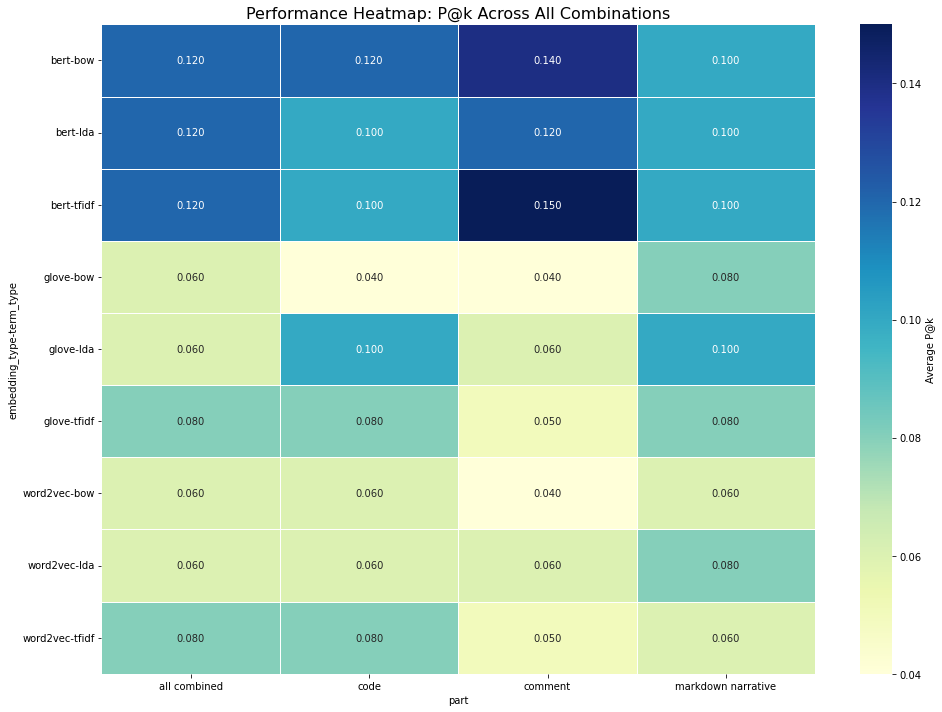

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('precision_at_k_results_new.csv')

df = df.dropna(subset=['p_at_k'])

heatmap_data = df.pivot_table(
    values='p_at_k',
    index=['embedding_type', 'term_type'],
    columns='part',
    aggfunc='mean'
)

heatmap_data = heatmap_data.sort_index()

plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".3f", 
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Average P@k'}
)

plt.title('Performance Heatmap: P@k Across All Combinations', fontsize=16)
plt.tight_layout()
plt.show()

Statistical differences in the values

In [55]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools


data = {
    'embedding-term type': [
        'BERT-BOW', 'BERT-LDA', 'BERT-TFIDF',
        'GloVe-BOW', 'GloVe-LDA', 'GloVe-TFIDF',
        'Word2Vec-BOW', 'Word2Vec-LDA', 'Word2Vec-TFIDF'
    ],
    'all_contents_combined': [0.120, 0.120, 0.120, 0.060, 0.060, 0.080, 0.060, 0.060, 0.080],
    'code': [0.120, 0.100, 0.100, 0.040, 0.100, 0.080, 0.060, 0.060, 0.080],
    'in_line_comment': [0.140, 0.120, 0.150, 0.040, 0.060, 0.050, 0.040, 0.060, 0.050],
    'markdown_narrative': [0.100, 0.100, 0.100, 0.080, 0.100, 0.080, 0.060, 0.080, 0.060]
}

column_mapping = {
    'all_contents_combined': 'all contents combined',
    'in_line_comment': 'in-line comment',
    'markdown_narrative': 'markdown narrative'
}

df = pd.DataFrame(data)
df = df.set_index('embedding-term type')
df = df.rename(columns=column_mapping)

print("Original Data:")
print(df)

columns = df.columns.tolist()

def paired_ttest(col1, col2, alpha=0.05):
    t_stat, p_value = stats.ttest_rel(df[col1], df[col2])
    significant = p_value < alpha
    mean_diff = df[col1].mean() - df[col2].mean()
    return {
        'comparison': f"{col1} vs {col2}",
        'mean_difference': round(mean_diff, 4),
        't_statistic': round(t_stat, 4),
        'p_value': round(p_value, 4),
        'significant': 'Yes' if significant else 'No'
    }

results = []
for col1, col2 in itertools.combinations(columns, 2):
    results.append(paired_ttest(col1, col2))

results_df = pd.DataFrame(results)
print("\nPairwise Comparison Results:")
print(results_df)

summary = pd.DataFrame({
    'mean': df.mean(),
    'std': df.std()
})
print("\nSummary Statistics:")
print(summary)


embedding_types = ['BERT', 'GloVe', 'Word2Vec']

print("\n\nAnalysis by Embedding Type:")
for embedding in embedding_types:
    subset = df[df.index.str.startswith(embedding)]
    print(f"\n{embedding} Mean P@k Scores:")
    print(subset.mean())

print("\nStatistical Tests Between Embedding Types:")
for col in columns:
    print(f"\nFeature: {col}")
    for emb1, emb2 in itertools.combinations(embedding_types, 2):
        subset1 = df[df.index.str.startswith(emb1)][col]
        subset2 = df[df.index.str.startswith(emb2)][col]
        t_stat, p_value = stats.ttest_ind(subset1, subset2, equal_var=False)  
        print(f"{emb1} vs {emb2}: t={t_stat:.4f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}")

comprehensive_table = pd.DataFrame(index=embedding_types)

for col in columns:
    for embedding in embedding_types:
        subset = df[df.index.str.startswith(embedding)][col]
        comprehensive_table.loc[embedding, col] = f"{subset.mean():.3f} ± {subset.std():.3f}"

print("\nComprehensive Table (Mean ± Std):")
print(comprehensive_table)

Original Data:
                     all contents combined  code  in-line comment  \
embedding-term type                                                 
BERT-BOW                              0.12  0.12             0.14   
BERT-LDA                              0.12  0.10             0.12   
BERT-TFIDF                            0.12  0.10             0.15   
GloVe-BOW                             0.06  0.04             0.04   
GloVe-LDA                             0.06  0.10             0.06   
GloVe-TFIDF                           0.08  0.08             0.05   
Word2Vec-BOW                          0.06  0.06             0.04   
Word2Vec-LDA                          0.06  0.06             0.06   
Word2Vec-TFIDF                        0.08  0.08             0.05   

                     markdown narrative  
embedding-term type                      
BERT-BOW                           0.10  
BERT-LDA                           0.10  
BERT-TFIDF                         0.10  
GloVe-BOW      

In [56]:
import numpy as np
import pandas as pd
from scipy import stats

data = {
    'embedding': [
        'BERT-BOW', 'BERT-LDA', 'BERT-TFIDF',
        'GloVe-BOW', 'GloVe-LDA', 'GloVe-TFIDF',
        'Word2Vec-BOW', 'Word2Vec-LDA', 'Word2Vec-TFIDF'
    ],
    'all_contents_combined': [0.120, 0.120, 0.120, 0.060, 0.060, 0.080, 0.060, 0.060, 0.080],
    'code': [0.120, 0.100, 0.100, 0.040, 0.100, 0.080, 0.060, 0.060, 0.080],
    'in_line_comment': [0.140, 0.120, 0.150, 0.040, 0.060, 0.050, 0.040, 0.060, 0.050],
    'markdown_narrative': [0.100, 0.100, 0.100, 0.080, 0.100, 0.080, 0.060, 0.080, 0.060]
}

df = pd.DataFrame(data)

df['embedding_type'] = df['embedding'].str.split('-').str[0]

print("Original DataFrame with embedding type:")
print(df)

df['average_score'] = df[['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].mean(axis=1)

print("\nDataFrame with average scores across all features:")
print(df[['embedding', 'embedding_type', 'average_score']])

embedding_means = df.groupby('embedding_type')['average_score'].mean()
print("\nMean score by embedding type:")
print(embedding_means)

def compare_embedding_types(df, type1, type2):
    # Get scores for type1
    type1_scores = []
    for _, row in df[df['embedding_type'] == type1].iterrows():
        type1_scores.extend([
            row['all_contents_combined'],
            row['code'],
            row['in_line_comment'],
            row['markdown_narrative']
        ])
    
    # Get scores for type2
    type2_scores = []
    for _, row in df[df['embedding_type'] == type2].iterrows():
        type2_scores.extend([
            row['all_contents_combined'],
            row['code'],
            row['in_line_comment'],
            row['markdown_narrative']
        ])
    
    mean_diff = np.mean(type1_scores) - np.mean(type2_scores)
    
    t_stat, p_value = stats.ttest_ind(type1_scores, type2_scores, equal_var=False)
    
    return {
        'comparison': f"{type1} vs {type2}",
        'type1_mean': np.mean(type1_scores),
        'type2_mean': np.mean(type2_scores),
        'mean_difference': mean_diff,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

embedding_types = ['BERT', 'GloVe', 'Word2Vec']
comparison_results = []

for i in range(len(embedding_types)):
    for j in range(i+1, len(embedding_types)):
        type1 = embedding_types[i]
        type2 = embedding_types[j]
        result = compare_embedding_types(df, type1, type2)
        comparison_results.append(result)

comparison_df = pd.DataFrame(comparison_results)
print("\nPairwise comparison results:")
print(comparison_df.round(4))

print("\nAggregated table data:")
for _, row in comparison_df.iterrows():
    print(f"{row['comparison']}: Mean Diff = {row['mean_difference']:.4f}, p-value = {row['p_value']:.4f}, Significant = {'Yes' if row['significant'] else 'No'}")

bert_scores = df[df['embedding_type'] == 'BERT'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()
glove_scores = df[df['embedding_type'] == 'GloVe'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()
word2vec_scores = df[df['embedding_type'] == 'Word2Vec'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()

print("\nDetailed scores by embedding type:")
print("BERT scores:", bert_scores)
print("GloVe scores:", glove_scores)
print("Word2Vec scores:", word2vec_scores)

print("\nBERT vs GloVe t-test:")
t_bert_glove, p_bert_glove = stats.ttest_ind(bert_scores, glove_scores, equal_var=False)
print(f"t-statistic: {t_bert_glove:.4f}, p-value: {p_bert_glove:.4f}")
print(f"Mean difference: {np.mean(bert_scores) - np.mean(glove_scores):.4f}")

print("\nBERT vs Word2Vec t-test:")
t_bert_word2vec, p_bert_word2vec = stats.ttest_ind(bert_scores, word2vec_scores, equal_var=False)
print(f"t-statistic: {t_bert_word2vec:.4f}, p-value: {p_bert_word2vec:.4f}")
print(f"Mean difference: {np.mean(bert_scores) - np.mean(word2vec_scores):.4f}")

print("\nGloVe vs Word2Vec t-test:")
t_glove_word2vec, p_glove_word2vec = stats.ttest_ind(glove_scores, word2vec_scores, equal_var=False)
print(f"t-statistic: {t_glove_word2vec:.4f}, p-value: {p_glove_word2vec:.4f}")
print(f"Mean difference: {np.mean(glove_scores) - np.mean(word2vec_scores):.4f}")

Original DataFrame with embedding type:
        embedding  all_contents_combined  code  in_line_comment  \
0        BERT-BOW                   0.12  0.12             0.14   
1        BERT-LDA                   0.12  0.10             0.12   
2      BERT-TFIDF                   0.12  0.10             0.15   
3       GloVe-BOW                   0.06  0.04             0.04   
4       GloVe-LDA                   0.06  0.10             0.06   
5     GloVe-TFIDF                   0.08  0.08             0.05   
6    Word2Vec-BOW                   0.06  0.06             0.04   
7    Word2Vec-LDA                   0.06  0.06             0.06   
8  Word2Vec-TFIDF                   0.08  0.08             0.05   

   markdown_narrative embedding_type  
0                0.10           BERT  
1                0.10           BERT  
2                0.10           BERT  
3                0.08          GloVe  
4                0.10          GloVe  
5                0.08          GloVe  
6               

In [57]:
import numpy as np
import pandas as pd
from scipy import stats
data = {
    'embedding_term_type': [
        'BERT-BOW', 'BERT-LDA', 'BERT-TFIDF',
        'GloVe-BOW', 'GloVe-LDA', 'GloVe-TFIDF',
        'Word2Vec-BOW', 'Word2Vec-LDA', 'Word2Vec-TFIDF'
    ],
    'all_contents_combined': [0.120, 0.120, 0.120, 0.060, 0.060, 0.080, 0.060, 0.060, 0.080],
    'code': [0.120, 0.100, 0.100, 0.040, 0.100, 0.080, 0.060, 0.060, 0.080],
    'in_line_comment': [0.140, 0.120, 0.150, 0.040, 0.060, 0.050, 0.040, 0.060, 0.050],
    'markdown_narrative': [0.100, 0.100, 0.100, 0.080, 0.100, 0.080, 0.060, 0.080, 0.060]
}

df = pd.DataFrame(data)
df[['embedding_type', 'term_type']] = df['embedding_term_type'].str.split('-', expand=True)

print("Original DataFrame with embedding type and term type:")
print(df)
df['average_score'] = df[['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].mean(axis=1)

print("\nDataFrame with average scores across all features:")
print(df[['embedding_term_type', 'embedding_type', 'term_type', 'average_score']])

term_type_means = df.groupby('term_type')['average_score'].mean()
print("\nMean score by term type:")
print(term_type_means)

def compare_term_types(df, type1, type2):
    # Get scores for type1
    type1_scores = []
    for _, row in df[df['term_type'] == type1].iterrows():
        type1_scores.extend([
            row['all_contents_combined'],
            row['code'],
            row['in_line_comment'],
            row['markdown_narrative']
        ])
    
    # Get scores for type2
    type2_scores = []
    for _, row in df[df['term_type'] == type2].iterrows():
        type2_scores.extend([
            row['all_contents_combined'],
            row['code'],
            row['in_line_comment'],
            row['markdown_narrative']
        ])
    
    # Calculate mean difference
    mean_diff = np.mean(type1_scores) - np.mean(type2_scores)
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(type1_scores, type2_scores, equal_var=False)
    
    return {
        'comparison': f"{type1} vs {type2}",
        'type1_mean': np.mean(type1_scores),
        'type2_mean': np.mean(type2_scores),
        'mean_difference': mean_diff,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }


term_types = ['BOW', 'LDA', 'TFIDF']
comparison_results = []

for i in range(len(term_types)):
    for j in range(i+1, len(term_types)):
        type1 = term_types[i]
        type2 = term_types[j]
        result = compare_term_types(df, type1, type2)
        comparison_results.append(result)


comparison_df = pd.DataFrame(comparison_results)
print("\nPairwise comparison results:")
print(comparison_df.round(4))


print("\nComprehensive statistics by term type:")
for term_type in term_types:
    term_data = df[df['term_type'] == term_type]
    all_combined_mean = term_data['all_contents_combined'].mean()
    all_combined_std = term_data['all_contents_combined'].std()
    
    code_mean = term_data['code'].mean()
    code_std = term_data['code'].std()
    
    comment_mean = term_data['in_line_comment'].mean()
    comment_std = term_data['in_line_comment'].std()
    
    narrative_mean = term_data['markdown_narrative'].mean()
    narrative_std = term_data['markdown_narrative'].std()
    
    overall_mean = term_data['average_score'].mean()
    overall_std = term_data['average_score'].std()
    
    print(f"\n{term_type}:")
    print(f"All contents combined: {all_combined_mean:.3f} ± {all_combined_std:.3f}")
    print(f"Code: {code_mean:.3f} ± {code_std:.3f}")
    print(f"In-line comment: {comment_mean:.3f} ± {comment_std:.3f}")
    print(f"Markdown narrative: {narrative_mean:.3f} ± {narrative_std:.3f}")
    print(f"Overall average: {overall_mean:.3f} ± {overall_std:.3f}")
bow_scores = df[df['term_type'] == 'BOW'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()
lda_scores = df[df['term_type'] == 'LDA'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()
tfidf_scores = df[df['term_type'] == 'TFIDF'][['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative']].values.flatten()

print("\nDetailed scores by term type:")
print("BOW scores:", bow_scores)
print("LDA scores:", lda_scores)
print("TFIDF scores:", tfidf_scores)

print("\nBOW vs LDA t-test:")
t_bow_lda, p_bow_lda = stats.ttest_ind(bow_scores, lda_scores, equal_var=False)
print(f"t-statistic: {t_bow_lda:.4f}, p-value: {p_bow_lda:.4f}")
print(f"Mean difference: {np.mean(bow_scores) - np.mean(lda_scores):.4f}")

print("\nBOW vs TFIDF t-test:")
t_bow_tfidf, p_bow_tfidf = stats.ttest_ind(bow_scores, tfidf_scores, equal_var=False)
print(f"t-statistic: {t_bow_tfidf:.4f}, p-value: {p_bow_tfidf:.4f}")
print(f"Mean difference: {np.mean(bow_scores) - np.mean(tfidf_scores):.4f}")

print("\nLDA vs TFIDF t-test:")
t_lda_tfidf, p_lda_tfidf = stats.ttest_ind(lda_scores, tfidf_scores, equal_var=False)
print(f"t-statistic: {t_lda_tfidf:.4f}, p-value: {p_lda_tfidf:.4f}")
print(f"Mean difference: {np.mean(lda_scores) - np.mean(tfidf_scores):.4f}")

term_type_summary = pd.DataFrame(index=term_types)

for feature in ['all_contents_combined', 'code', 'in_line_comment', 'markdown_narrative', 'average_score']:
    feature_label = feature if feature != 'average_score' else 'overall'
    for term_type in term_types:
        mean_val = df[df['term_type'] == term_type][feature].mean()
        std_val = df[df['term_type'] == term_type][feature].std()
        term_type_summary.loc[term_type, feature_label] = f"{mean_val:.3f} ± {std_val:.3f}"

print("\nComprehensive Table by Term Type:")
print(term_type_summary)

Original DataFrame with embedding type and term type:
  embedding_term_type  all_contents_combined  code  in_line_comment  \
0            BERT-BOW                   0.12  0.12             0.14   
1            BERT-LDA                   0.12  0.10             0.12   
2          BERT-TFIDF                   0.12  0.10             0.15   
3           GloVe-BOW                   0.06  0.04             0.04   
4           GloVe-LDA                   0.06  0.10             0.06   
5         GloVe-TFIDF                   0.08  0.08             0.05   
6        Word2Vec-BOW                   0.06  0.06             0.04   
7        Word2Vec-LDA                   0.06  0.06             0.06   
8      Word2Vec-TFIDF                   0.08  0.08             0.05   

   markdown_narrative embedding_type term_type  
0                0.10           BERT       BOW  
1                0.10           BERT       LDA  
2                0.10           BERT     TFIDF  
3                0.08          GloVe   

# RQ2

### Significant Features (95%) Coef Table

In [36]:
import pandas as pd
import numpy as np

df = pd.read_csv('all_coefficient_statistics.csv')

significant_features = df[df['IsSignificant'] == True]

key_domains = [
    'image', 'time series analysis', 'data visualization', 
    'image segmentation', 'text generation', 'model comparison',
    'image classification', 'binary classification', 'model explainability', 
    'image generator', 'recommender systems', 'text pre-processing',
    'wandb', 'data cleaning', 'linear regression', 'neural networks',
    'transfer learning', 'computer vision', 'selective kernel',
    'image augmentation', 'gradient boosting', 'exploratory data analysis',
    'weight standardization', 'eyes and vision', 'gpu', 'convolution',
    'feature engineering', 'religion and belief systems', 'decision tree',
    'heart conditions', 'movies and tv shows', 'text'
]

important_features = [
    'num_lines', 'narrative_size', 'num_classes', 
    'tensor_lib_numpy', 'tensor_lib_tensorflow', 'tensor_lib_torch', 'tensor_lib_jax',
    'op_dot', 'op_matmul', 'op_multiply', 'op_add', 'op_subtract', 'op_divide', 'op_transpose', 'op_reshape', 'op_concatenate', 'op_stack', 'op_split', 'op_slice', 'op_gather', 'op_scatter', 'op_einsum', 'op_conv', 'op_pool'
]

pivot_table = pd.pivot_table(
    significant_features,
    values='Coefficient',
    index='Feature',
    columns='Class',
    aggfunc='first'  # Take the first value since there should be only one per feature-class combo
)

pivot_table = pivot_table.loc[pivot_table.index.isin(important_features), 
                             [col for col in pivot_table.columns if col in key_domains]]

formatted_table = pivot_table.applymap(lambda x: f"{x:.4f}" if pd.notnull(x) else "")

print(formatted_table)

Class                 binary classification computer vision convolution  \
Feature                                                                   
narrative_size                      -0.8406          1.6778     -3.1298   
num_classes                                          2.6892               
num_lines                                                       -6.2860   
op_add                                                                    
op_concatenate                                      -3.5375     -2.3532   
op_conv                                                                   
op_divide                                           -0.8410               
op_dot                                              -0.9217               
op_einsum                                                                 
op_gather                                           -1.7443               
op_matmul                            0.1801         -4.4402     -1.1541   
op_multiply              

### Corr Matrix

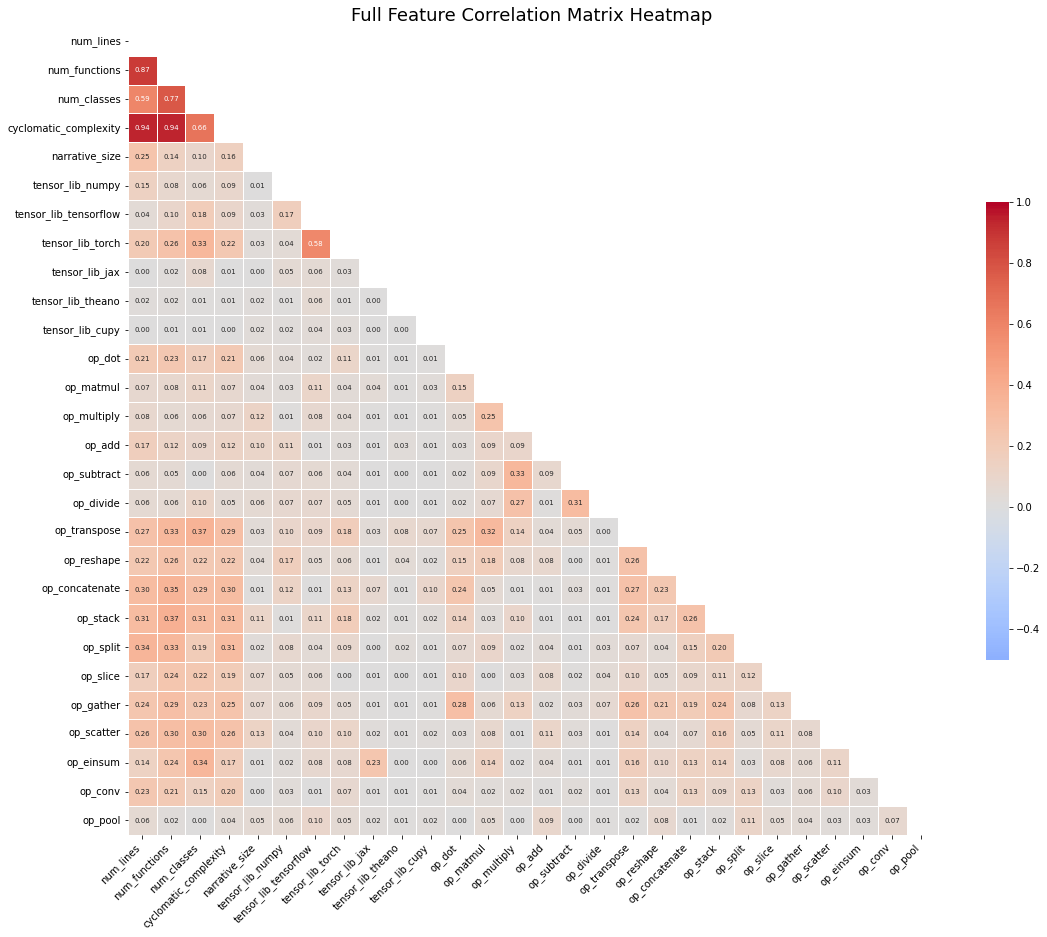

In [42]:
full_corr = pd.read_csv('corr_matrix.csv', index_col=0)

mask = np.triu(np.ones_like(full_corr, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(
    full_corr, 
    mask=mask,
    cmap='coolwarm',
    vmax=1.0,
    vmin=-0.5,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7}
)

plt.title('Full Feature Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('full_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Feature Coefficients Heatmap

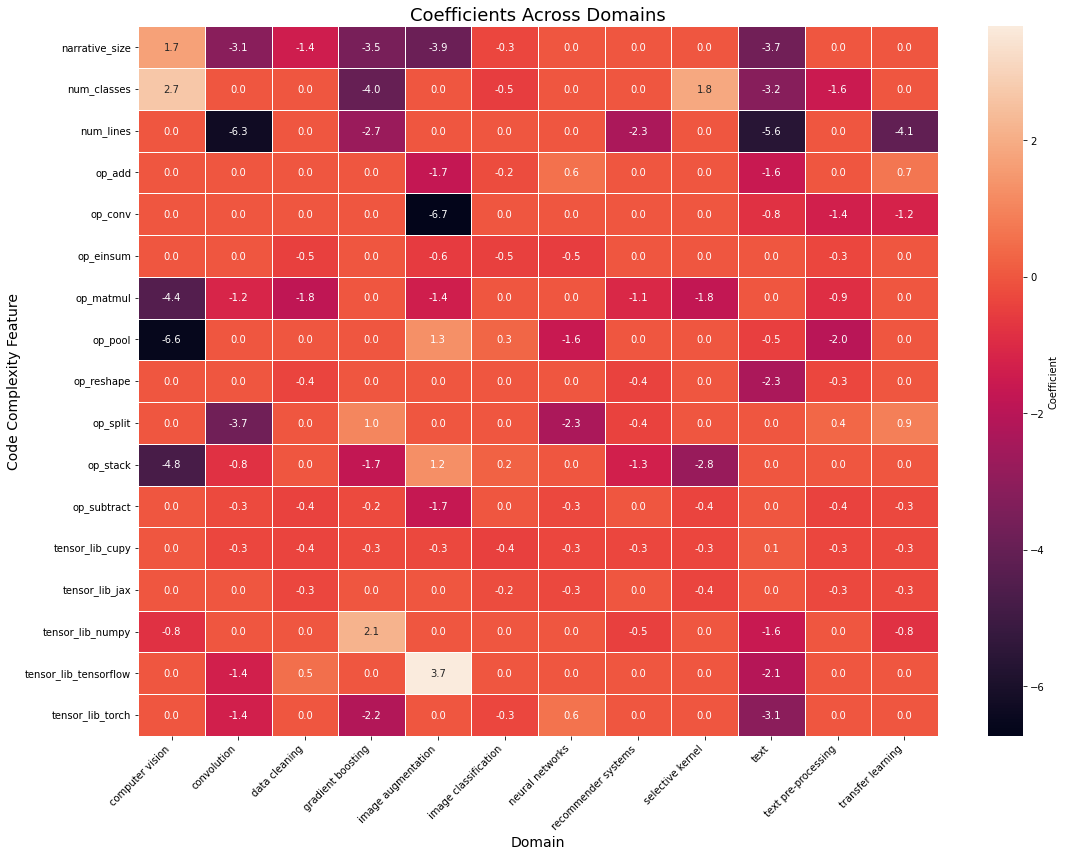

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('all_coefficient_statistics.csv')

significant_features = df[df['IsSignificant'] == True]

domain_feature_counts = significant_features['Class'].value_counts()
top_domains = domain_feature_counts.head(12).index.tolist()

important_features = [
    'num_lines', 'narrative_size', 'num_classes', 
    'tensor_lib_numpy', 'tensor_lib_tensorflow', 'tensor_lib_torch', 'tensor_lib_jax',
    'tensor_lib_cupy', 'op_reshape', 'op_conv', 'op_pool', 'op_einsum', 
    'op_matmul', 'op_subtract', 'op_add', 'op_split', 'op_stack'
]

importance_pivot = pd.pivot_table(
    significant_features,
    values='Coefficient',
    index='Feature',
    columns='Class',
    aggfunc='first'
)

importance_pivot = importance_pivot.loc[
    [f for f in importance_pivot.index if f in important_features and f != 'intercept'], 
    [col for col in importance_pivot.columns if col in top_domains]
]

importance_pivot = importance_pivot.fillna(0)

plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    importance_pivot,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Coefficient'}
)

plt.title('Coefficients Across Domains', fontsize=18)
plt.ylabel('Code Complexity Feature', fontsize=14)
plt.xlabel('Domain', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Coef Forest Plot for top 5 Domains with highest significant features

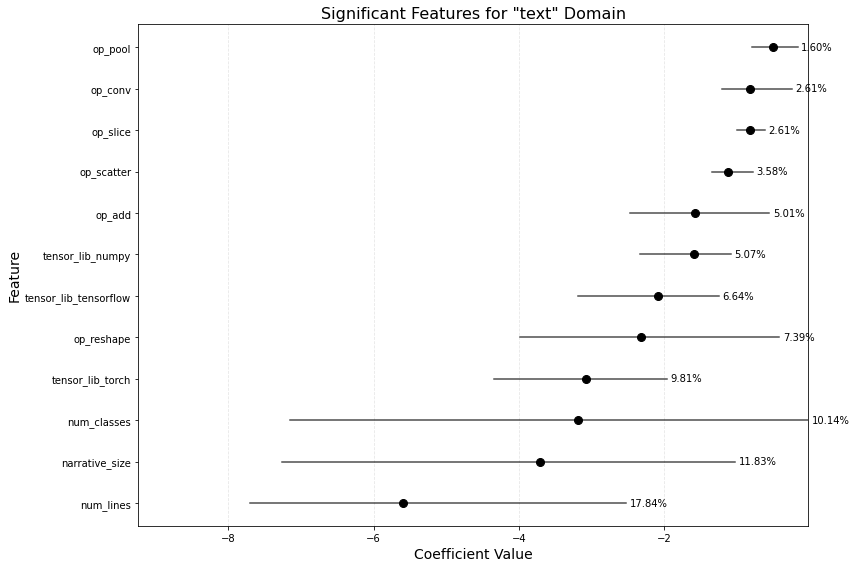

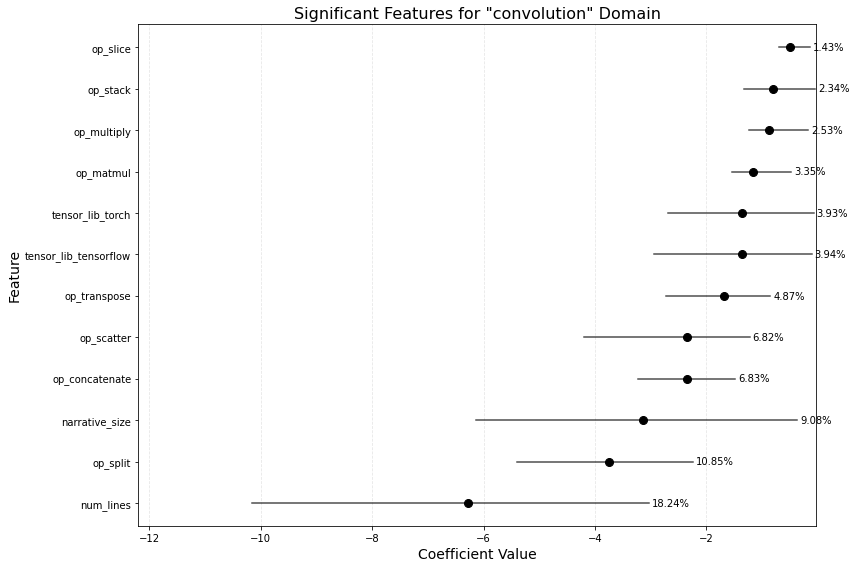

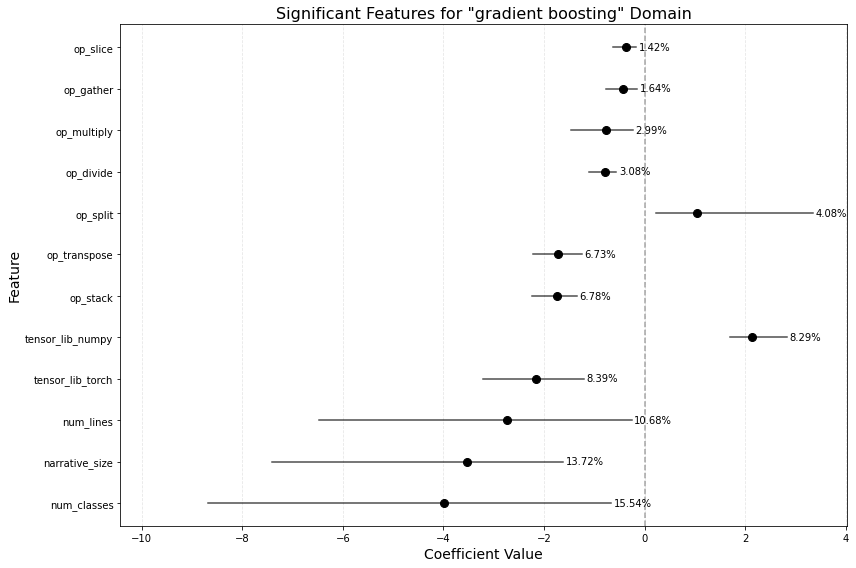

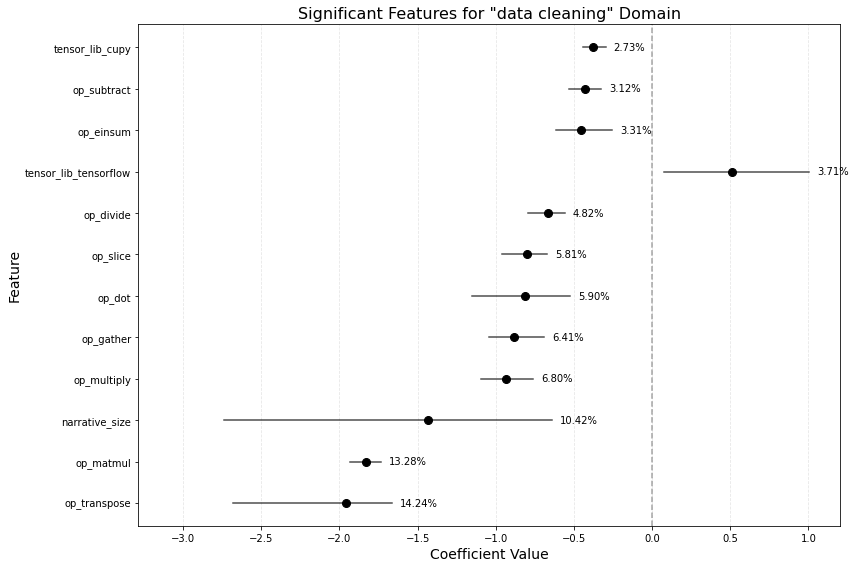

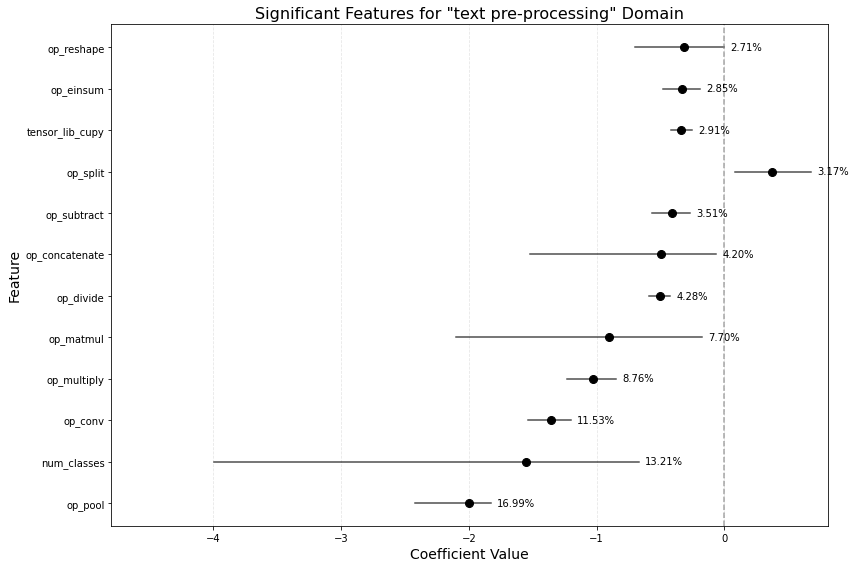

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('all_coefficient_statistics.csv')

significant_features = df[(df['IsSignificant'] == True) & (df['Feature'] != 'intercept')]

domain_feature_counts = significant_features['Class'].value_counts()
top_domains = domain_feature_counts.head(5).index.tolist()

top_domains = ["image", "time series analysis", "data visualization", "image segmentation", "text generation"]

for domain in top_domains:
    domain_data = significant_features[significant_features['Class'] == domain].copy()
    domain_data['AbsCoef'] = np.abs(domain_data['Coefficient'])
    domain_data = domain_data.sort_values('AbsCoef', ascending=False).head(12)
    
    domain_data = domain_data.reset_index(drop=True)
    
    plt.figure(figsize=(12, 8))
    
    for i, row in domain_data.iterrows():
        plt.plot([row['Lower_CI'], row['Upper_CI']], [i, i], 'k-', alpha=0.7)
        plt.plot(row['Coefficient'], i, 'ko', markersize=8)
    
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    plt.yticks(range(len(domain_data)), domain_data['Feature'])
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Significant Features for "{domain}" Domain', fontsize=16)
    
    for i, row in domain_data.iterrows():
        plt.text(row['Upper_CI'] + 0.05, i, f"{row['Importance']:.2f}%", va='center', fontsize=10)
    
    x_min = min(domain_data['Lower_CI']) * 1.2 if min(domain_data['Lower_CI']) < 0 else min(domain_data['Lower_CI']) * 0.8
    x_max = max(domain_data['Upper_CI']) * 1.2 if max(domain_data['Upper_CI']) > 0 else max(domain_data['Upper_CI']) * 0.8
    plt.xlim(x_min, x_max)
    
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

### Code Complexity Distribution by Domain

Domains are selected as the top-5 by frequency. Metrics are self-selected

INCL. OUTLIERS

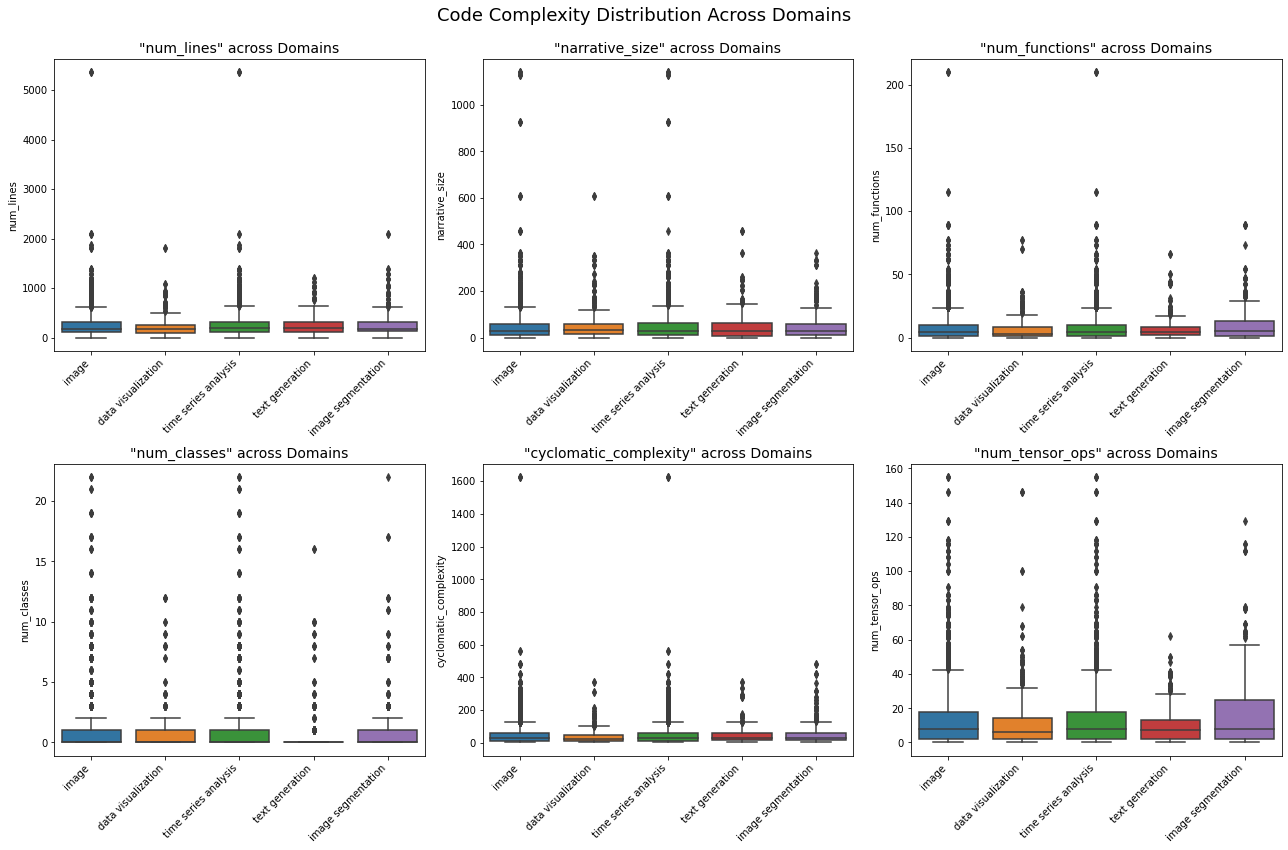

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('code_complexity.csv')

key_metrics = [
    'num_lines', 'narrative_size', 'num_functions', 
    'num_classes', 'cyclomatic_complexity', 'num_tensor_ops'
]

domain_counts = df['top1_domain'].value_counts()
top_domains = domain_counts.head(5).index.tolist()

filtered_df = df[df['top1_domain'].isin(top_domains)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(key_metrics):
    ax = axes[i]
    sns.boxplot(x='top1_domain', y=metric, data=filtered_df, ax=ax)
    ax.set_title(f'"{metric}" across Domains', fontsize=14)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # # Add mean values as text
    # means = filtered_df.groupby('top1_domain')[metric].mean()
    # for j, domain in enumerate(ax.get_xticklabels()):
    #     domain_name = domain.get_text()
    #     if domain_name in means.index:
    #         ax.text(
    #             j, 
    #             means[domain_name] * 1.05, 
    #             f'μ={means[domain_name]:.1f}', 
    #             ha='center',
    #             fontsize=8
    #         )

plt.suptitle('Code Complexity Distribution Across Domains', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('code_complexity_by_domain.png', dpi=300)
plt.show()

EXCL. 1.5IQR OUTLIER

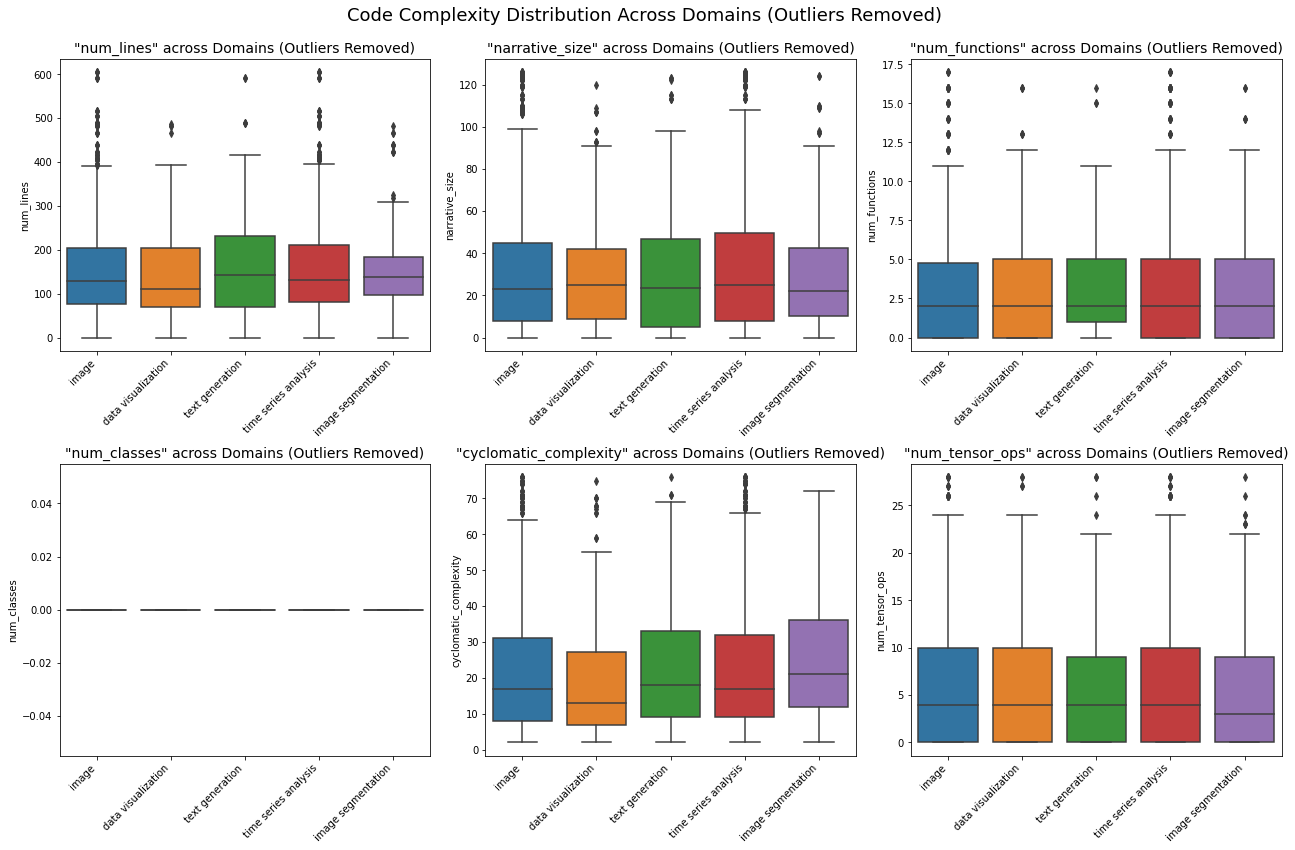

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('code_complexity.csv')

key_metrics = [
    'num_lines', 'narrative_size', 'num_functions', 
    'num_classes', 'cyclomatic_complexity', 'num_tensor_ops'
]

domain_counts = df['top1_domain'].value_counts()
top_domains = domain_counts.head(5).index.tolist()

filtered_df = df[df['top1_domain'].isin(top_domains)]

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cleaned_df = filtered_df.copy()
for metric in key_metrics:
    cleaned_df = remove_outliers(cleaned_df, metric)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(key_metrics):
    ax = axes[i]
    sns.boxplot(x='top1_domain', y=metric, data=cleaned_df, ax=ax)
    ax.set_title(f'"{metric}" across Domains (Outliers Removed)', fontsize=14)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    

plt.suptitle('Code Complexity Distribution Across Domains (Outliers Removed)', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
